In [1]:
import numpy as np 
import time

from matplotlib import pyplot as plt
import matplotlib

In [2]:
from imaging_functions import show_map, show_map_3d
from noise_functions import perlin_generator, julia, my_perl
from mountains import mountain, voron_mountain
from landscape import landscape_gen

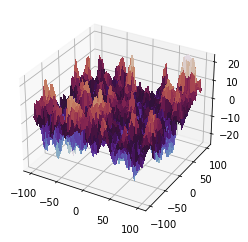

In [3]:
X, Y, Z = show_map_3d(my_perl, 100,100,2,neg_octaves=4,octaves=1)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)
plt.show()

In [5]:
my_mountain = mountain(1,2, erosion=0, size=2)

2.0
0.0
2.0


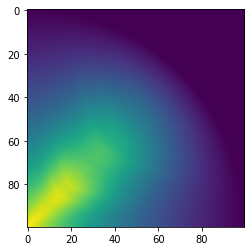

In [6]:
print(my_mountain.get_height(1,2))
X, Y, Z = show_map_3d(my_mountain, 100,100,0.02,[2,1])#0.04,[1,2])#

print(np.min(Z))
print(np.max(Z))
plt.imshow(Z)

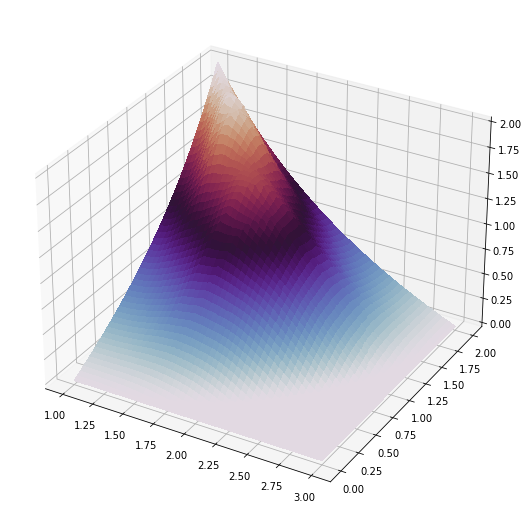

In [12]:

#fig, ax = plt.subplots(subplot_kw={"projection": "3d", "fig_size": (20,20)})

fig = plt.figure(figsize=(20,20))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [4]:
my_mountain = voron_mountain(1,2,size=9,erosion = 0.1)

4.716194628827957
0.0
4.947152954480191


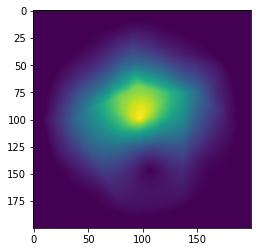

In [5]:
print(my_mountain.get_height(1,2))
X, Y, Z = show_map_3d(my_mountain, 200,200,0.1,[1,2])#
print(np.min(Z))
print(np.max(Z))
plt.imshow(Z)

-2.630639232746405
3.4515294086507233


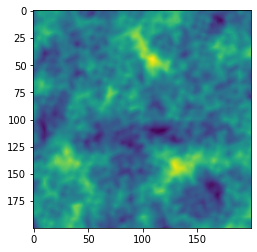

In [242]:

X, Y, Z = show_map_3d(my_perl, 200,200,0.1,[1,2],octaves=2,neg_octaves = 2, fade=0.75)#
print(np.min(Z))
print(np.max(Z))
plt.imshow(Z)

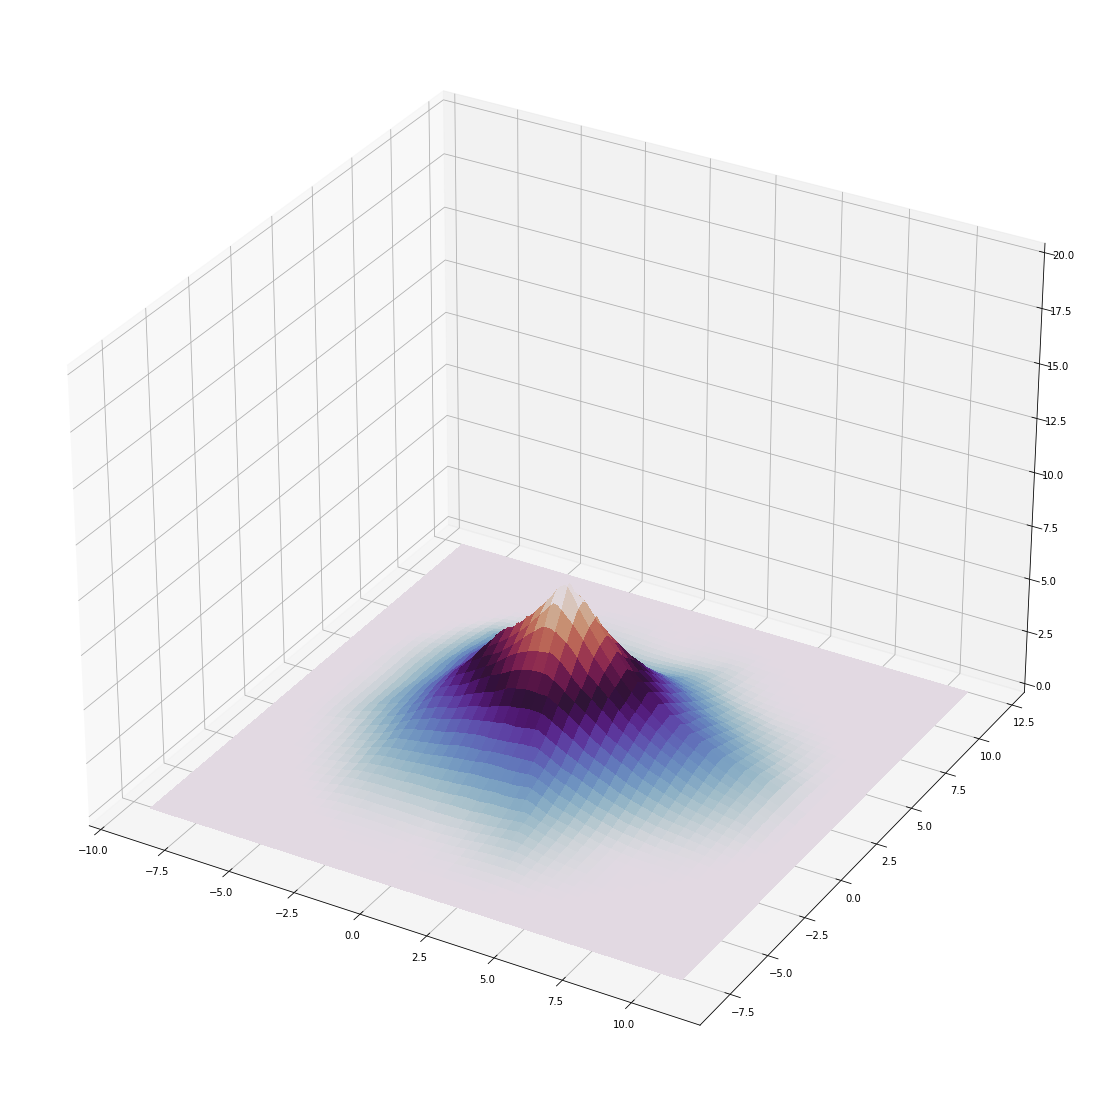

In [14]:
fig = plt.figure(figsize=(20,20))


ax = fig.add_subplot(projection='3d')

surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)
ax.set_zlim(0,20)
plt.show()

In [6]:
my_landscape = landscape_gen(200,200,num_plates=10)

In [7]:
start = time.time()
X,Y,Z = show_map_3d(my_landscape,10,10,0.02,[my_landscape.lat*0.5,my_landscape.long*0.5])
print(np.min(Z))

print(np.max(Z))
end = time.time()
print(end-start)


0.7965269082673117
0.7965269082673117
0.030916690826416016


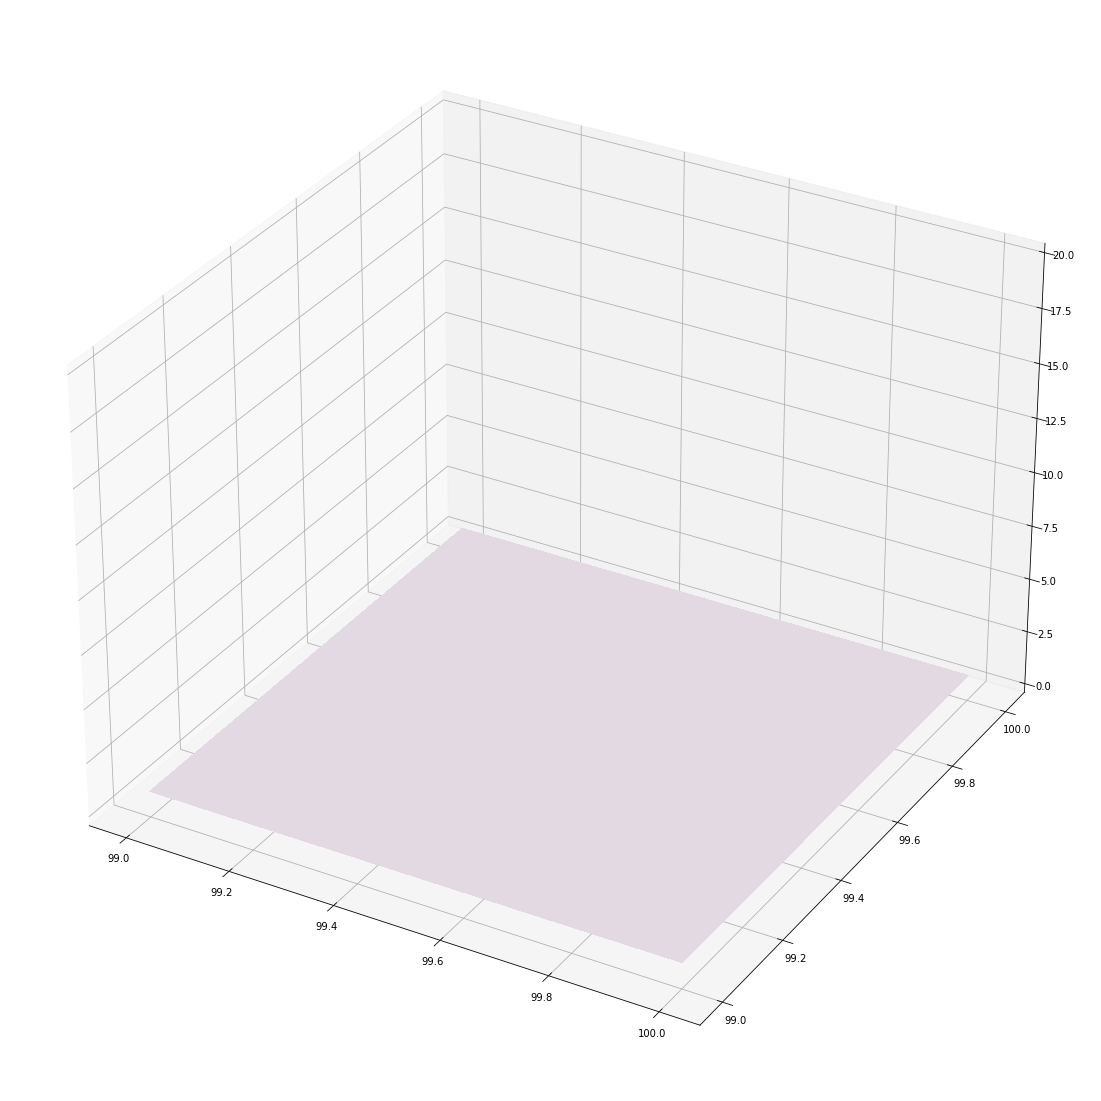

In [8]:
fig = plt.figure(figsize=(20,20))
# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, linewidth=0, cmap = matplotlib.cm.twilight, antialiased=False)

ax.set_zlim(0, 20)

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

C:\Users\eddie\AppData\Local\Temp/ipykernel_1712/20185634.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asarray(my_landscape.mountains_tiled)


(668, 668)

6411

TypeError: 'int' object is not iterable

In [ ]:
start = time.time()
graphic_1 = show_map(my_landscape,2000,2000,1,[my_landscape.lat*0.5,my_landscape.long*0.5])
print(np.min(graphic_1))

print(np.max(graphic_1))

end = time.time()
print(end-start)
plt.figure(figsize = (20,20))
plt.imshow(graphic_1)

In [363]:
for i in range(100):
    graphic = show_map(my_landscape,20,20,10/(i+1),[1000 + 0.36*i, 1000 - 6.69*i])
    graphic = graphic / np.max(graphic)
    graphic = graphic - np.min(graphic)
    graphic = graphic * 255
    graphic = graphic.astype(np.uint8)
    cv2.imwrite(f"Documents/Blender Projects/mountain generator/python_images/{i}_{min(graphic)}_to_{max(graphic)}.png",graphic)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [339]:
1000-331.45

668.55